## SIFT-IMU Integration: Discarding Images That Are Too Far Apart

In [1]:
import numpy as np
from math import acos, sin, cos, tan

## Helper Functions WE MUST TRANSCRIBE TO C++

In [2]:
def sind(x):
    return sin(np.deg2rad(x))

def cosd(x):
    return cos(np.deg2rad(x))

def tand(x):
    return tan(np.deg2rad(x))

def acosd(x):
    return np.rad2deg(acos(x))

def convert_ffYPR_matrix(alpha, beta, gamma):
    '''
    This function returns the YPR in the fixed world frame.
    Data collected from the Vector Nav is in the body frame and must be transformed
     in order to do the necessary math later
    '''
    
    # yaw
    R_alpha = np.array([[1, 0, 0],
             [0, cosd(alpha), -sind(alpha)],
             [0, sind(alpha), cosd(alpha)]])

    # pitch
    R_beta = np.array([[cosd(beta), 0, sind(beta)],
            [0, 1, 0],
            [-sind(beta), 0, cosd(beta)]])

    # roll
    R_gamma = np.array([[cosd(gamma), -sind(gamma), 0],
             [sind(gamma), cosd(gamma), 0],
             [0, 0, 1]])
    
    R = R_gamma*R_beta*R_alpha

    return R

In [3]:
def get_ffYPR_theta(bYPR):
    """Accepts body frame YPR, returns the FIXED FRAME YPR"""
    
    R = convert_ffYPR_matrix(bYPR[0], bYPR[1], bYPR[2])

    # Ensure that these are the correct graphs... eg matching ffpitch to bpitch...
    ffyaw = acosd(np.dot(R[:,1], [0, 1, 0]))
    ffpitch = acosd(np.dot(R[:,2], [0, 0, 1]))
    ffroll = acosd(np.dot(R[:,0], [1, 0, 0]))
    
    ADJ_ffpitch = ffpitch*-1 + 180
    #ADJ_ffroll = ffroll*-1 + 180 <-- USE THIS WHEN NOT USING ABG CONVERSION
    
    ffYPR = np.array([ffyaw, ADJ_ffpitch, ffroll])
    
    return ffYPR

In [4]:
def map_roll(x):
    return abs(np.mod(x - 180.0, 360.0) - 180.0)

In [5]:
# NEED TO DETERMINE HOW MUCH ROTATION IS TOO MUCH
# EG SET THRESHOLD TO AN ACTUAL NUMBER THAT HAS MEANING
def compare_change(theta_prev, theta_new, threshold=50, verbose=False):
    """
    PURPOSE: Compares the new orientation to the previous orientation.
    INPUTS:
        1. theta_prev: YPR state of the last accepted image. E.g. previous orientation
        2. theta_new: the current YPR that you want to compare 
        3. threshold: maximum angle deviation that we allow. 50 IS AN ARBITRARY VALUE
        - Note you can pass in a single int, or you can pass in a 3x1 vector of ints
        - If the latter, then you can test the YPR against their own max threshold
    OUTPUT: Boolean telling whether or not we should discard the captured image
    
    COMPARISON
    Roll: I am unsure about how much the nose cone will roll while descending, we have no data thus far
    - This should be measured wrt 180 deg, as if it does a full 360 turn then we're just back at zero
    - Rotation about this is equivalent to 2D rotations of the flattened landing site image
    - SIFT has proven to be pretty tolerant of this based on drone testing
    Pitch: we don't expect much change, this one is not critical
    Yaw: this is our main focus, as changes in yaw dictate which the camera is facing when capturing images
    
    MAKE SURE THAT THE DEFINED YPR MATCH THE GIVEN YPR OF THE IMU IN THE GIVEN ORIENTATION
    """
    
    if type(threshold) is int or type(threshold) is float:
        # You have specified a single acceptable value, shared for all 3 axes
        roll_thresh, pitch_thresh, yaw_thresh = threshold, threshold, threshold
        individual = False
    elif len(threshold)==3:
        # You have given YPR separate thresholds
        roll_thresh, pitch_thresh, yaw_thresh = threshold[0], threshold[1], threshold[2]
        individual = True
    else:
        raise("TypeError: threshold parameter should either be an int or a 3x1 vector of ints")
    
    should_accept = True
    
    # Map the roll so it is triangular, peaks at 180. 0->0, 180->180, 360->0
    #roll_prev = map_roll(theta_prev[0])
    #roll_new = map_roll(theta_new[0])
    
    ###################################################################################
    # We don't know how much rotation SIFT can handle when in combination
    # We don't know how much rotation SIFT can handle in any individual direction either
    ###################################################################################
    
    if individual:
        # DEALING WITH INDIVUDAL AXIS ROTATIONS
        # Roll
        #if roll_prev - roll_new > roll_thresh:
        #    print("Too much ROLL detected.  Image should be discarded")
        #    return False
        # Yaw
        if theta_prev[0] - theta_new[0] > yaw_thresh:
            if verbose:
                print("Too much YAW detected.  Image should be discarded")
            return False
        # Pitch
        elif theta_prev[1] - theta_new[1] > pitch_thresh:
            if verbose:
                print("Too much PITCH detected.  Image should be discarded")
            return False
        # Roll
        elif theta_prev[2] - theta_new[2] > roll_thresh:
            if verbose:
                print("Too much ROLL detected.  Image should be discarded")
            return False
        
    else:
        # DEALING WITH ALL AXES ROTATIONS (E.G. IN COMBINATION)
        #theta_prev[0] = roll_prev
        #theta_new[0] = roll_new
        
        dTheta = np.array(theta_new) - np.array(theta_prev)
        
        #if np.linalg.norm(dTheta) > threshold: 
        # ^Norm doesn't have a direct meaning like the difference in angle does
        if (dTheta > threshold).sum() > 0:
            return False

    return should_accept

In [6]:
def convert_abg(bYPR):
    # Normally, alpha beta gamma are yaw pitch roll
    # Our IMU placement is such that the roll axis of the IMU is the pitch of the vehicle
    # So let's just switch things around
    
    gamma = bYPR[0]  # Yaw
    alpha = bYPR[1]  # Pitch
    beta = bYPR[2]  # Roll

    # Essentially we just returned a switched around version of bYPR
    return np.array([alpha, beta, gamma])

## Functions That Are C++ Only

In [7]:
def get_IMU_data():
    """Accepts IMU object, returns the BODY FRAME YPR, aka alpha, beta, gamma
    This needs to interface with the IMU, probably in real time, so might actually need to be in C++
    There's some C++ object/class that already exists for the IMU, we just have to draw from it now
    """
    
    #mIMU->YPR
    print("You have not written the function to accpet IMU data.")
    return np.array([0, 0, 0])

## Functions SIFT Code Must Interface With

In [8]:
# This builds the first orientation matrix

def init_orientation(bYPR):
    # Account for IMU misalignment with launch vehicle frame
    bYPR = convert_abg(bYPR)
    # Convert IMU data from body frame to fixed frame
    ffYPR = get_ffYPR_theta(bYPR)
    return ffYPR

In [52]:
# Put this before the incoming images

def judge_image(prev_orientation, bYPR, threshold_vec=[30,30,30]):
    """
    INPUT: 
        1. Prev_ori is the camera orientation from the last accepted image
        2. bYPR is the most recent IMU data related to the image in question
        3. OPTIONAL threshold_vec allows you to specify the max angle deviation for the YPR, respectively
    RETURNS: 
        1. Boolean of whether or not to accept the new image
        2. The orientaiton of the last accepted image
    
    -- Could pass in the current orientation, not sure if it's easier to do that or 
    to just call a function that gets the IMU data within this function
    """
    
    # Account for IMU misalignment with launch vehicle frame
    bYPR = convert_abg(bYPR)
    # Convert IMU data from body frame to fixed frame
    ffYPR = get_ffYPR_theta(bYPR)
    # Compare current thetas to previous orientation
    if compare_change(prev_orientation, ffYPR, threshold=threshold_vec):
        return True, ffYPR
    else:
        return False, prev_orientation

## Unit Testing

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [54]:
################## DATA FRAME ##################
datafile = '../Fullscale21.csv'
fields = ['Timestamp',
  'Roll', 'Pitch', 'Yaw']

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
all_time = df['Timestamp'].values

tdata = all_time
tdata = tdata - all_time[0]

yaw = df['Yaw'].values
pitch = df['Pitch'].values
roll = df['Roll'].values

In [55]:
def get_IMU_data_UT(df, row_index):
    bYPR = np.array([df.iloc[row_index, 1], df.iloc[row_index, 2], df.iloc[row_index, 3]])
    return bYPR

In [56]:
# Sanity check

bYPR = get_IMU_data_UT(df, 0)
print(bYPR)
po = init_orientation(bYPR)
print(po)

print("------------")
bYPR = get_IMU_data_UT(df, 1)
po = init_orientation(bYPR)
print(po)

[-139.761       0.463927 -179.001   ]
[139.75878055   1.10145697  40.24929038]
------------
[139.69476394   1.101505    40.31324656]


In [57]:
L = len(tdata)
bYPR = get_IMU_data_UT(df, 0)
po = init_orientation(bYPR)

Ls = 93

my_bools = [0] * L
my_pos = [0] * L
my_inputs = [0] * L

# To simulate 1 frame per second: range(0, L, 43)
for i, val in enumerate(range(L)): 
    # Collect incoming IMU data in real time
    bYPR = get_IMU_data_UT(df, val)
    my_bool, po = judge_image(po, bYPR)
    
    my_bools[i] = my_bool
    my_pos[i] = po
    my_inputs[i] = bYPR

d = {"my_bool": my_bools, "po": my_pos, "IO": my_inputs}
df2 = pd.DataFrame(d)

ffyaw = [pos[0] for pos in my_pos]
ffpitch = [pos[1] for pos in my_pos]
ffroll = [pos[2] for pos in my_pos]

In [58]:
prev_yaw = [pos[2] for pos in my_pos][0:70]
input_yaw = [pos[2] for pos in my_inputs][0:70]

#d = {"my_bool": my_bools[0:70], "prev_yaw": prev_yaw, "input_yaw": input_yaw}
#df3 = pd.DataFrame(d)
#df3.head(70)

## Performance Evaluation
> Note that you can observe how frequently.  Just because the status is False (0) doesn't mean that the shown angle is the cause: e.g. it could be false because of another angle; there is a single boolean shared between all three angles, naturally.

- Note that at 10 degrees, the bool status is low for most of the time, and we have very choppy data, but even at just 30 degrees, the bool status is active most of the time.  My suspicion is that SIFT could probably survive 50+ degrees, and this probably greatly varies with the axis.

In [61]:
raise Exception("Do not run the following code")

Exception: Do not run the following code

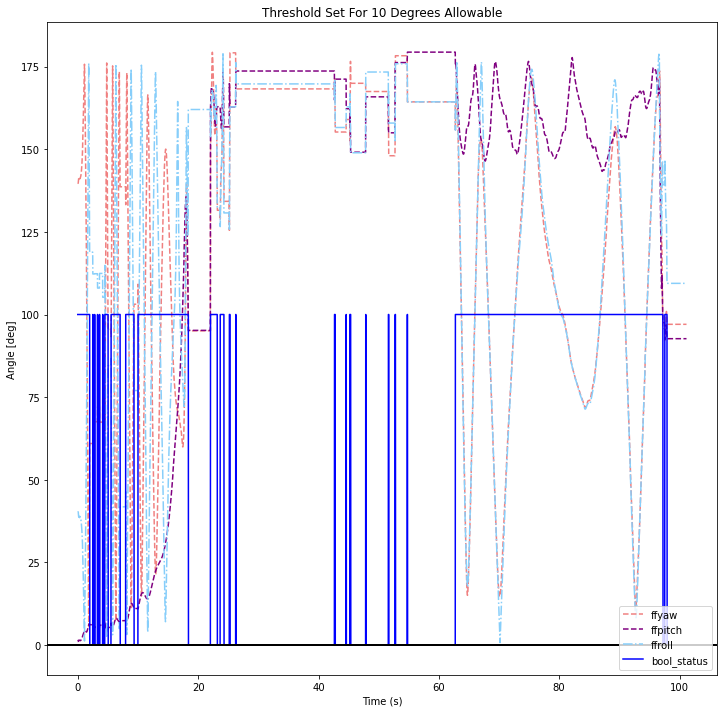

In [51]:
fig1 = plt.figure(1, figsize=(12,12))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ffyaw, linestyle='--', color='lightcoral', label='ffyaw')
l2 = ax.plot(tdata, ffpitch, linestyle='--', color='purple', label='ffpitch')
l2 = ax.plot(tdata, ffroll, linestyle='-.', color='lightskyblue', label='ffroll')
l4 = ax.plot(tdata, np.array(my_bools)*100, 'b', label='bool_status')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Threshold Set For 10 Degrees Allowable")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Angle [deg]")
ax.legend(loc='lower right')
plt.show()

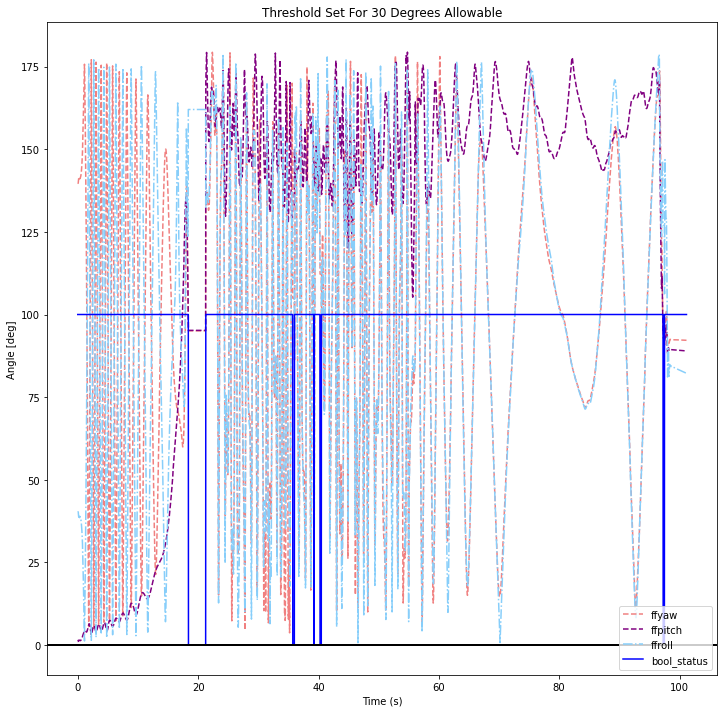

In [59]:
fig1 = plt.figure(1, figsize=(12,12))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ffyaw, linestyle='--', color='lightcoral', label='ffyaw')
l2 = ax.plot(tdata, ffpitch, linestyle='--', color='purple', label='ffpitch')
l2 = ax.plot(tdata, ffroll, linestyle='-.', color='lightskyblue', label='ffroll')
l4 = ax.plot(tdata, np.array(my_bools)*100, 'b', label='bool_status')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Threshold Set For 30 Degrees Allowable")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Angle [deg]")
ax.legend(loc='lower right')
plt.show()

## Not sure which yaw we actually want...
> I chose the ffyaw since that's what makes sense.  Last year they just added 180 to it to change what it was centered about.

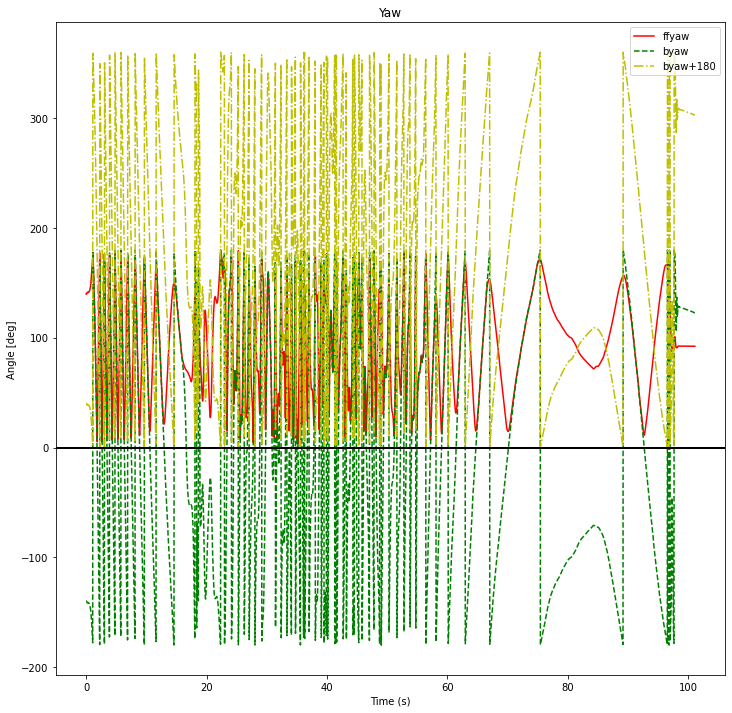

In [19]:
ffyaw = [pos[0] for pos in my_pos]
ffpitch = [pos[1] for pos in my_pos]
ffroll = [pos[2] for pos in my_pos]

fig1 = plt.figure(1, figsize=(12,12))
ax = plt.subplot(111)
l2 = ax.plot(tdata, ffyaw, 'r', label='ffyaw')
l3 = ax.plot(tdata, yaw, '--g', label='byaw')
l4 = ax.plot(tdata, yaw+180, '-.y', label='byaw+180')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()